In [1]:
import requests
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
import os.path
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# From https://stackoverflow.com/questions/50786266/writing-dictionary-of-dataframes-to-file
import csv
import pandas as pd

def save_dict_df(dictex, keys_filename="keys.txt", data_folder="hourly_stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="keys.txt", data_folder="hourly_stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [3]:
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft', 'apple', 'snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT', 'AAPL', 'SNAP']
stock_columns = ['open', 'high', 'low', 'close', 'volume']

In [4]:
#create kw_list 
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

In [5]:
# Get 3-month ago trend data. May need to run a couple times to make sure it doesn't time out. 
def getTrendDataDF(kw_list, pull_data=False, dates='today 3-m', pytrends_df_filename="hourly_pytrends.csv"):
    # Retrieve the cached trend data
    if not pull_data and os.path.isfile(pytrends_df_filename):
        df = pd.read_csv(pytrends_df_filename, index_col="date")
        
    else: # Construct the dataframe by making pytrends calls
        df = pd.DataFrame()
        data = {}
        #print(df.empty)
        pytrends = TrendReq(hl='en-US', tz=360)
        for kw in kw_list:
            df_temp = pytrends.get_historical_interest([kw], year_start=2019, month_start=11, day_start=25, hour_start=0, year_end=2019, month_end=11, day_end=29, hour_end=23)
            df_temp = df_temp.drop(['isPartial'], axis=1)
            # print(kw)
            data[kw] = df_temp
        for kw in kw_list:
            if df.empty:
                df = data[kw]
            else:
                df = df.join(data[kw])
        df.to_csv(pytrends_df_filename)
    #reverse df rows
    df = df.iloc[::-1]
    return df

In [6]:
# Get Stock Hourly info for past 7 days
def getHourlyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_INTRADAY'
        api_key = ''
        interval = '30min'
        outputsize = 'full'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                .format(ts, symbol, interval, api_key, outputsize)
            request = requests.get(link)
            data = json.loads(request.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            while "Time Series (30min)" not in data:
                print('...sleeping...')
                time.sleep(70)
                link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, interval, api_key, outputsize)
                request = requests.get(link)
                data = json.loads(request.text)
            stock_data_per_hour = json.dumps(data["Time Series (30min)"])
            df_temp = pd.read_json(stock_data_per_hour).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [7]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [8]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [9]:
def getOverlapDateData(company_name, dict_stocks, df_trends): 
    new_df_trends = getTrends(company_name, df_trends)
    
    joint_times = getJointTimes(dict_stocks[company_name], new_df_trends)
    new_df_stocks = dict_stocks[company_name].loc[dict_stocks[company_name]['times'].isin(joint_times)]
    new_df_stocks = new_df_stocks.reset_index() 
    
    new_df_trends = new_df_trends.loc[new_df_trends.index.isin(joint_times)]
    new_df_trends = new_df_trends.reset_index()
    new_df_trends.columns = ['_'.join(x.split()) for x in list(new_df_trends.columns) if len(x) > 1]
    df_all_data = new_df_stocks.join(new_df_trends)
    return df_all_data


In [10]:
def trainMultipleRegression(y_col, parameter_cols, training_data): 
    formula = y_col + ' ~ 1'
    for i in parameter_cols: 
        formula = formula + " + " + i

    result = sm.formula.ols(formula=formula, data=training_data).fit()
    return result

In [11]:
def plotMultipleRegressionAndGetMSE(company, result, y_col, cols, all_data, training_data, testing_data):
    y_pred = result.predict()
    plt.plot(range(len(all_data[y_col])) , all_data[y_col])
    plt.plot(range(50), result.predict(training_data[cols]), '-')
    plt.plot(range(50, len(df_all_data[y_col])), result.predict(testing_data[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Multiple Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    
    MSE = mean_squared_error(result.predict(testing_data[cols]), testing_data[y_col]) / (np.mean(testing_data[y_col]) * np.std(testing_data[y_col]))
    return MSE

In [12]:
def getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train):
    df_all_data_test = df_all_data_train[40:]
    df_all_data_train = df_all_data_train[:40]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 2000, 10):
        clf = Ridge(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))

    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, clf

In [13]:
#ridge regression

def trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, parameter_cols, df_all_data_train, df_all_data_test) : 
    bestAlpha, clf = getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train)
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    
    #plot data with training and test data
    clf = Ridge(alpha=bestAlpha)
    clf.fit(X, y) 
    plt.plot(range(len(df_all_data[y_col])) , df_all_data[y_col])
    plt.plot(range(50), clf.predict(df_all_data_train[cols]), '-')
    plt.plot(range(50, len(df_all_data[y_col])), clf.predict(df_all_data_test[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Ridge Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    
    print(clf.get_params())
    MSE = mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]) / (np.mean(df_all_data_test[y_col]) * np.std(df_all_data_test[y_col]))
    return MSE

In [14]:
def getMovingAvgAndStdDev(col_name, num_days, df_all_data):
    # Moving average and stdev past X days
    col_movingAvg = []
    col_stdev = []
    
    num_days_to_average = 10
    for i in range(len(df_all_data)):
        sum_to_avg = 0
        nums = []
        num_to_avg = min(num_days_to_average, len(df_all_data) - i) - 1
        for j in range(1, num_to_avg):
            sum_to_avg += df_all_data[col][i + j]
            nums.append(df_all_data[col][i + j])
        avg = sum_to_avg / (num_to_avg if num_to_avg > 0 else 1)
        stdev = np.std((nums if nums else [0]))

        col_movingAvg.append(avg)
        col_stdev.append(stdev)
    return col_movingAvg, col_stdev

In [15]:
def getAllParamCols(df_all_data):
    cols = list(df_all_data.columns)
    cols.remove('profit')
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    cols.remove('mid')
    return cols

In [16]:
# Get trend data
df_trends = getTrendDataDF(kw_list)

In [17]:
# Get stock data
dict_stocks = getHourlyStockInfoDict(company_symbol)

# Lasso Regression with Hourly Data

In [18]:
# Imports
import requests
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn import linear_model
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
import os.path


**Helper Functions**

In [19]:
def save_dict_df(dictex, keys_filename="keys.txt", data_folder="hourly_stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="keys.txt", data_folder="hourly_stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [20]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [21]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [22]:
# Define Company Keyterms and Symbols
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft','apple','snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT','AAPL','SNAP']

In [23]:
#Create Key Word List
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

**Gather Google trends data**

In [43]:
# Get Hourly trends data from pytrends
# If there is a server 500 error, try changing the dates to this past week! 
def getHourlyTrends(company_symbol, pull_data=False, trends_df_filename="hourly_pytrends.csv"):
    if not pull_data and os.path.isfile(trends_df_filename):
        trends_df = pd.read_csv(trends_df_filename, index_col="date")
    else :
        df = pd.DataFrame()
        data = {}
        pytrends = TrendReq(hl='en-US', tz=360)
        for kw in kw_list:
            print(kw)
            df_temp = pytrends.get_historical_interest([kw], year_start=2019, month_start=11, day_start=27, hour_start=0, year_end=2019, month_end=12, day_end=3, hour_end=23, sleep=30)
            if 'isPartial' in df_temp.columns: 
                df_temp = df_temp.drop(['isPartial'], axis=1)
            data[kw] = df_temp
        for kw in kw_list:
            if df.empty:
                df = data[kw]
            else:
                df = df.join(data[kw])
                
        print("finished kw forloop")
        trends_df = df
        df.to_csv(trends_df_filename)
    return trends_df
        

In [44]:
df_trends = getHourlyTrends(company_symbol,True)

tesla report
tesla good
tesla bad
tesla up
tesla down
tesla stock
facebook report
facebook good
facebook bad
facebook up
facebook down
facebook stock
microsoft report
microsoft good
microsoft bad
microsoft up
microsoft down
microsoft stock
amazon report
amazon good
amazon bad
amazon up
amazon down
amazon stock
google report
google good
google bad
google up
google down
google stock
uber report
uber good
uber bad
uber up
uber down
uber stock
lyft report
lyft good
lyft bad
lyft up
lyft down
lyft stock
apple report
apple good
apple bad
apple up
apple down
apple stock
The request failed: Google returned a response with code 429.
snap report
The request failed: Google returned a response with code 429.
The request failed: Google returned a response with code 429.
snap good
The request failed: Google returned a response with code 429.
The request failed: Google returned a response with code 429.
snap bad
The request failed: Google returned a response with code 429.
The request failed: Google 

In [45]:
# Inspect Data
df_trends.head()

,tesla report,tesla good,tesla bad,tesla up,tesla down,tesla stock,facebook report,facebook good,facebook bad,facebook up,...,lyft bad,lyft up,lyft down,lyft stock,apple report,apple good,apple bad,apple up,apple down,apple stock
date,,,,,,,,,,,,,,,,,,,,,
2019-11-27 00:00:00,94,91,94,100,100,85,96,81,75,74,...,15,69,26,77,82,82,81,71,35,60
2019-11-27 01:00:00,100,86,77,87,76,80,93,84,71,75,...,76,46,64,66,64,80,82,71,31,56
2019-11-27 02:00:00,84,90,72,71,58,73,85,98,70,86,...,31,48,39,46,61,81,88,72,34,48
2019-11-27 03:00:00,70,100,92,68,83,74,93,95,60,86,...,48,62,27,60,53,77,84,66,32,46
2019-11-27 04:00:00,65,57,82,60,55,64,89,79,67,84,...,83,39,42,58,53,75,72,55,27,40


**Gather Stock Data: Alpha Vantage**

In [27]:
# Get Stock Hourly info for past 7 days
def getHourlyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_INTRADAY'
        api_key = ''
        interval = '30min'
        outputsize = 'full'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            print(symbol)
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                .format(ts, symbol, interval, api_key, outputsize)
            request = requests.get(link)
            data = json.loads(request.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            while "Time Series (30min)" not in data:
                print('...sleeping...')
                time.sleep(70)
                link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, interval, api_key, outputsize)
                request = requests.get(link)
                data = json.loads(request.text)
            stock_data_per_hour = json.dumps(data["Time Series (30min)"])
            df_temp = pd.read_json(stock_data_per_hour).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [28]:
df_stocks = getHourlyStockInfoDict(company_symbol,True)

TSLA
FB
MSFT
AMZN
GOOGL
UBER
...sleeping...
LYFT
AAPL
SNAP


In [29]:
# Gather stock data for each individual company
#df_stocks = {}
#for s in company_symbol:
#    print(s)
#    res = getIntraday1minDF(s)
    # data limit reached
#    while res.empty:
#        time.sleep(10)
#        res = getIntraday1minDF(s)
    # add stock information to dictionary
#    df_stocks[s] = res

In [30]:
# Preview Stock Data
df_stocks['tesla'].tail()

,times,open,high,low,close,volume
372,2019-10-24 12:00:00,293.6600,298.2900,292.7000,297.5200,1643473.0
373,2019-10-24 11:30:00,295.2156,295.7645,292.8218,293.7024,1241653.0
374,2019-10-24 11:00:00,292.7300,296.0200,289.2200,295.1500,2866779.0
375,2019-10-24 10:30:00,297.4161,299.7806,292.3937,292.8809,3240948.0
376,2019-10-24 10:00:00,298.3700,304.9500,294.0200,297.4500,11841310.0


In [31]:
#reverse df rows
df_trends = df_trends.iloc[::-1]
df_trends.head()

,tesla report,tesla good,tesla bad,tesla up,tesla down,tesla stock,facebook report,facebook good,facebook bad,facebook up,...,uber stock,lyft report,lyft good,lyft bad,lyft up,lyft down,lyft stock,apple report,apple good,apple bad
date,,,,,,,,,,,,,,,,,,,,,
2019-12-03 23:00:00,66,47,45,26,47,61,93,87,92,67,...,56,63,74,76,63,25,64,78,69,83
2019-12-03 22:00:00,71,63,52,28,52,71,99,80,94,63,...,74,46,49,27,79,45,63,79,58,84
2019-12-03 21:00:00,60,64,40,37,36,76,90,79,91,67,...,80,65,43,47,54,69,72,82,51,71
2019-12-03 20:00:00,59,59,41,34,37,73,84,72,100,62,...,78,37,51,42,66,27,72,63,48,71
2019-12-03 19:00:00,71,50,43,31,35,69,83,67,87,63,...,76,28,31,60,49,25,71,72,46,64


**Merge Trend and Stock Data**

In [32]:
df_trends_stocks = {}
def cleanAndJoinData():
    for s,c in zip(company_symbol, companies):
        print(c)
        company_names = [x for x in list(df_trends.columns.values) if c in x]
        df_temp_trends = df_trends[company_names]
        
        # line up indexes 
        stock_times = list(df_stocks[c].times)
        trends_times = list(df_temp_trends.index)
        joint_times = list(set(stock_times) & set(trends_times)) 
        
        print(joint_times)
        df_temp_stocks = df_stocks[c].loc[df_stocks[c]['times'].isin(joint_times)]
        df_temp_stocks = df_temp_stocks.reset_index()
        df_temp_stocks = df_temp_stocks.iloc[::-1]
        df_temp_trends = df_temp_trends.loc[df_temp_trends.index.isin(joint_times)]
        df_temp_trends = df_temp_trends.reset_index()
        df_temp_trends.columns = ['_'.join(x.split()) for x in list(df_temp_trends.columns) if len(x) > 1]
        df_trends_stocks[c] = df_temp_stocks.join(df_temp_trends,lsuffix='_left', rsuffix='_right')
cleanAndJoinData()

tesla
[Timestamp('2019-12-03 15:00:00'), Timestamp('2019-12-03 16:00:00'), Timestamp('2019-12-02 14:00:00'), Timestamp('2019-12-02 11:00:00'), Timestamp('2019-11-29 12:00:00'), Timestamp('2019-12-03 13:00:00'), Timestamp('2019-11-29 10:00:00'), Timestamp('2019-11-27 14:00:00'), Timestamp('2019-12-02 12:00:00'), Timestamp('2019-12-02 10:00:00'), Timestamp('2019-12-03 10:00:00'), Timestamp('2019-12-03 14:00:00'), Timestamp('2019-12-03 11:00:00'), Timestamp('2019-11-29 11:00:00'), Timestamp('2019-11-27 12:00:00'), Timestamp('2019-11-27 13:00:00'), Timestamp('2019-11-29 13:00:00'), Timestamp('2019-11-27 11:00:00'), Timestamp('2019-12-02 13:00:00'), Timestamp('2019-11-27 15:00:00'), Timestamp('2019-12-02 15:00:00'), Timestamp('2019-12-03 12:00:00'), Timestamp('2019-11-27 10:00:00'), Timestamp('2019-12-02 16:00:00'), Timestamp('2019-11-27 16:00:00')]
facebook
[Timestamp('2019-12-03 15:00:00'), Timestamp('2019-12-03 16:00:00'), Timestamp('2019-12-02 14:00:00'), Timestamp('2019-12-02 11:00:00'

**Function for calculating new predictors**

In [33]:
def getMovingAvgAndStdDev(col_name, num_days, df_all_data):
    # Moving average and stdev past X days
    col_movingAvg = []
    col_stdev = []
    
    num_days_to_average = 10
    for i in range(len(df_all_data)):
        sum_to_avg = 0
        nums = []
        num_to_avg = min(num_days_to_average, len(df_all_data) - i) - 1
        for j in range(1, num_to_avg):
            sum_to_avg += df_all_data[col][i + j]
            nums.append(df_all_data[col][i + j])
        avg = sum_to_avg / (num_to_avg if num_to_avg > 0 else 1)
        stdev = np.std((nums if nums else [0]))

        col_movingAvg.append(avg)
        col_stdev.append(stdev)
    return col_movingAvg, col_stdev

**Add Additional Predictors to model**

In [34]:
def getAllParamCols(df_all_data):
    cols = list(df_all_data.columns)
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    cols.remove('profit')
    cols.remove('mid')
    cols.remove('volume_movingAvg')
    cols.remove('volume_stdev')
    cols.remove('profit_movingAvg')
    cols.remove('profit_stdev')
    cols.remove('mid_movingAvg')
    cols.remove('mid_stdev')
    return cols

In [35]:
# Add predictors
for company in df_trends_stocks: 
    # Calculate Profit For Each Company in Dict
    (df_trends_stocks[company])['profit'] = (df_trends_stocks[company])['open']-(df_trends_stocks[company])['close']
    (df_trends_stocks[company])['mid'] = ((df_trends_stocks[company])['high']+(df_trends_stocks[company])['low'])/2
    # Calculate Moving Averages and Standard Deviation for Stock Data
    # For Profit
    num_days_to_average = 10
    col = 'profit'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
    (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
    (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_trends_stocks[company][col+'_prev'] = col_prev
    # For Mid
    col = 'mid'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
    (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
    (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_trends_stocks[company][col+'_prev'] = col_prev
    # For Volume
    col = 'volume'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
    (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
    (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    cols = getAllParamCols(df_trends_stocks[company])
    col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_trends_stocks[company][col+'_prev'] = col_prev
    
    # Calculate Increment Over time
    for col in cols: 
        # Prev 
        col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        #df_all_data[col+'_prev'] = col_prev
        (df_trends_stocks[company])[col+'_prev'] = col_prev
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
        
        (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
        (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    # Reverse index order
    df_trends_stocks[company] = df_trends_stocks[company].iloc[::-1] 

**LASSO Regression Helper Functions**

In [36]:
# Methods for LASSO Regression
def getBestAlphaLASSORegression(y_col, parameter_cols, df_all_data_train):
    split = int(df_all_data_train.shape[0]/2)
    df_all_data_test = df_all_data_train[split:]
    df_all_data_train = df_all_data_train[:split]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 10000, 10):
        clf = linear_model.Lasso(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))

    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    bestMSE = min(MSE_test)
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, bestMSE

In [37]:
# Define Functions For Plotting LASSO Regression
def plotLASSO(company, alpha, label, predictors, df): 
    # Separate Data
    split = int(df.shape[0]/2)
    df_train = df[:split]
    df_test = df[split:]
    X_train = df_train[predictors]
    Y_train = df_train[label]
    X_test = df_test[predictors]
    Y_test = df_test[label]
    Y_labels = df[label]
    # Initialize Model w/ Optimal Alpha
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X_train, Y_train) 
    param_dict = dict(zip(clf.coef_, predictors))
    print("Parameter Estimates w/ LASSO : ",param_dict)
    # Make Predictions using optimal alpha value
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    # Plot test and train predictions against true labels
    
    fig1, ax1 = plt.subplots()
    ax1.plot(range(split), y_pred_train, color='r')
    ax1.plot(range(split, len(Y_labels)),y_pred_test, color='b')
    ax1.plot(range(len(Y_labels)),Y_labels, color='g')
    ax1.set_xlabel('Time in Hours')
    ax1.set_ylabel(label)
    ax1.set_title(label + ' Predictions with LASSO Regression for '+ company)

**Run regression and view dropped features for each company**

In [38]:
def columnsAll(company, label): 
    cols = df_trends_stocks[company].columns
    cols = list(cols)
    cols.remove('times')
    cols.remove('index')
    cols.remove('date')
    cols.remove(label)
    return cols

def columnsTrends(company, label): 
    cols = [x for x in list(df_trends_stocks[company].columns) if company in x]
    return cols

def columnsAverage(company, label): 
    cols = [x for x in list(df_trends_stocks[company].columns) if company not in x]
    cols.remove(label)
    cols.remove('times')
    cols.remove('index')
    cols.remove('date')
    cols.remove('open')
    cols.remove('volume')
    cols.remove('high')
    cols.remove('low')
    cols.remove('close')
    cols.remove('profit')
    return cols

# Plot Predictions w/ All Predictors

In [39]:
keys = ['All Predictors ', 'Just Trends ','Just Stock Data']
MSE = {key: None for key in keys}
MSE_companies = {company: MSE for company in companies}

alpha: 90
Training error = 0.2628668353619941
Testing error = 13.139523605071359

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -1.1393242347477235e-06: 'volume', -4.138220396181886e-06: 'volume_movingAvg', -4.384240568062365e-06: 'volume_stdev', 1.2765140430259844e-07: 'volume_prev'}
alpha: 90
Training error = 1.1032348616499161
Testing error = 4.568551444476596

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -2.4131713841324185e-07: 'volume', -3.0124927382621657e-06: 'volume_movingAvg', 9.976162285994468e-06: 'volume_stdev', 4.0241227360600496e-07: 'volume_prev'}
alpha: 9250
Training error = 0.32700648928317255
Testing error = 0.852932276095554

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -1.7059369261856566e-07: 'volume', -8.175299643019676e-07: 'volume_movingAvg', 3.133890258296019e-06: 'volume_stdev'}
alpha: 100
Training error = 56.87844129938315
Testing error = 1280.3957562854525

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -1.8077457232

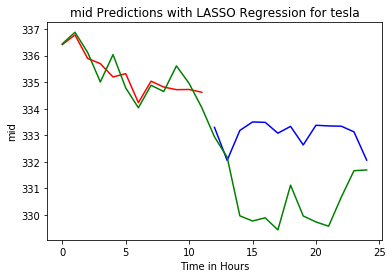

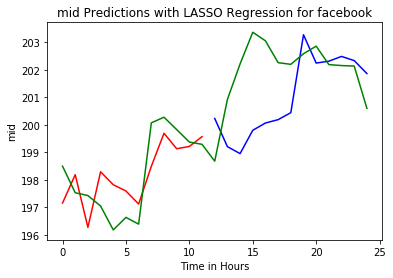

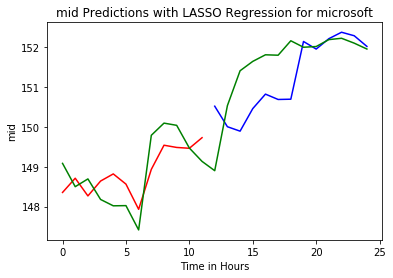

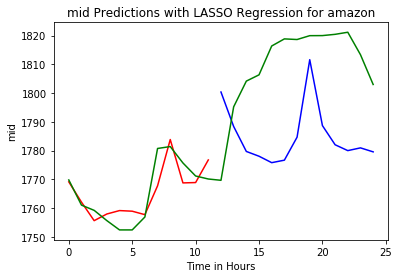

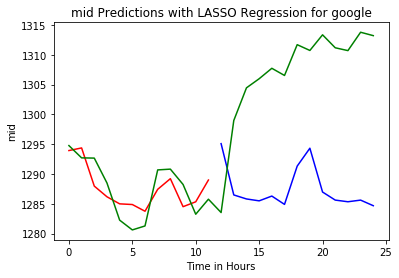

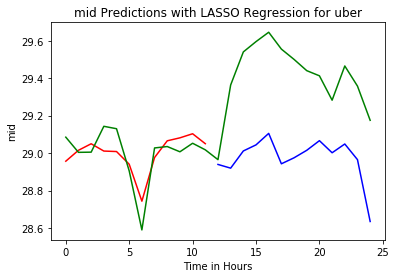

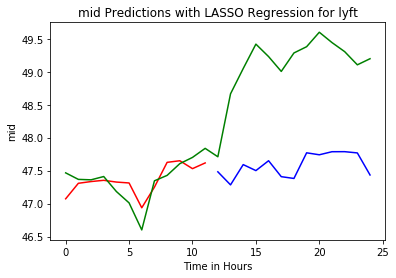

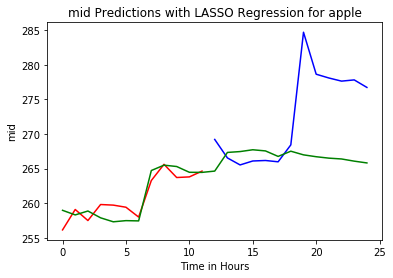

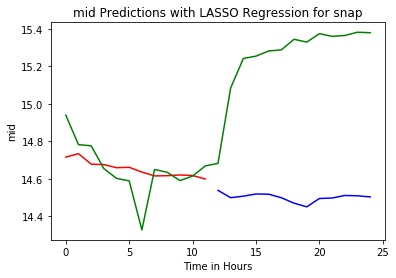

In [40]:
for company in companies: 
    # Prepare column list
    cols = columnsAll(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha, MSE = getBestAlphaLASSORegression('mid',cols,df_trends_stocks[company])
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_trends_stocks[company])
    # Plot MSE for LASSO Regression
    MSE_companies[company]['All Predictors']  = MSE

# Plot Predictions for Just Trends Data

In [41]:
for company in companies: 
    # Prepare column list
    cols = columnsTrends(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha = getBestAlphaLASSORegression('mid',cols,df_trends_stocks[company])
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_trends_stocks[company])
    # Plot MSE train and test for LASSO Regression
    MSE_companies[company]['Just Trends']  = MSE

alpha: 90
Training error = 0.7787878524305709
Testing error = 22.54306473891607



TypeError: only size-1 arrays can be converted to Python scalars

# Plot Predictions for Just Stock Data

In [ ]:
for company in companies: 
    # Prepare column list
    cols = columnsAverage(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha = getBestAlphaLASSORegression('mid',cols,df_trends_stocks[company])
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_trends_stocks[company])
    # Plot MSE train and test for LASSO Regression
    MSE_companies[company]['Just Stock Data']  = MSE

In [ ]:
print(MSE_companies)